In [24]:
# Configuration GPU pour éviter Out Of Memory
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Croissance mémoire GPU dynamique activée")
    except RuntimeError as e:
        print(f"Erreur config GPU: {e}")

Croissance mémoire GPU dynamique activée


In [ ]:
import tensorflow as tf
import numpy as np
import keras
import keras_nlp
import tensorflow_text as tf_text
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer

# Charger le dataset GoEmotions depuis Hugging Face
dataset = load_dataset("google-research-datasets/go_emotions", "simplified")

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})


In [26]:
print("Exemple train[0] :")
print(dataset["train"][0])

print("\nColonnes :")
print(dataset["train"].column_names)

print("\nLabel info :")
print(dataset["train"].features["labels"])

# Liste des 28 émotions de GoEmotions
label_names = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 
               'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 
               'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 
               'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 
               'relief', 'remorse', 'sadness', 'surprise', 'neutral']

print("\nNoms des 28 labels :", label_names)

Exemple train[0] :
{'text': "My favourite food is anything I didn't have to cook myself.", 'labels': [27], 'id': 'eebbqej'}

Colonnes :
['text', 'labels', 'id']

Label info :
List(ClassLabel(names=['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']))

Noms des 28 labels : ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


# Transformation du dataset en TensorFlow

In [27]:
# Récupération des splits Huggingface
train_hf = dataset["train"]
val_hf = dataset["validation"]
test_hf = dataset["test"]

# Conversion des labels en format multi-label (vecteur de 0 et 1)
def convert_to_multilabel(example):
    """Convertit la liste d'indices en vecteur binaire de 28 éléments"""
    label_vector = np.zeros(28, dtype=np.float32)
    for idx in example["labels"]:
        label_vector[idx] = 1.0
    return label_vector

train_texts = list(train_hf["text"])
train_labels = [convert_to_multilabel(ex) for ex in train_hf]

val_texts = list(val_hf["text"])
val_labels = [convert_to_multilabel(ex) for ex in val_hf]

test_texts = list(test_hf["text"])
test_labels = [convert_to_multilabel(ex) for ex in test_hf]

print("Train:", len(train_texts), "exemples")
print("Val:", len(val_texts), "exemples")
print("Test:", len(test_texts), "exemples")

num_labels = 28
print("Labels :", label_names[:num_labels], " (num_labels =", num_labels, ")")
print("\nExemple de label multi-label :", train_labels[0])
print("Émotions actives :", [label_names[i] for i, v in enumerate(train_labels[0]) if v == 1.0])

Train: 43410 exemples
Val: 5426 exemples
Test: 5427 exemples
Labels : ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']  (num_labels = 28 )

Exemple de label multi-label : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1.]
Émotions actives : ['neutral']


In [28]:
# Création du dataset TensorFlow
train_ds_raw = tf.data.Dataset.from_tensor_slices((train_texts, train_labels))
val_ds_raw = tf.data.Dataset.from_tensor_slices((val_texts, val_labels))
test_ds_raw = tf.data.Dataset.from_tensor_slices((test_texts, test_labels))

# Vérif
for x, y in train_ds_raw.take(1):
    print("Text brut :", x.numpy().decode("utf-8"))
    print("Label vector shape :", y.shape)
    print("Label vector :", y.numpy()[:num_labels], "...")

Text brut : My favourite food is anything I didn't have to cook myself.
Label vector shape : (28,)
Label vector : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1.] ...


In [29]:
# Vérification de la configuration GPU pour optimiser l'entraînement
import tensorflow as tf

# Configuration pour croissance mémoire dynamique
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Croissance mémoire GPU dynamique activée")
    except RuntimeError as e:
        print(e)

print("\nPériphériques physiques disponibles :")
print(tf.config.list_physical_devices())

if gpus:
    print(f"\nGPU détecté : {len(gpus)} GPU(s) disponible(s)")
    for gpu in gpus:
        print(f"  - {gpu}")
    print("\nTensorFlow utilisera automatiquement le GPU pour l'entraînement")
else:
    print("\nAucun GPU détecté")

Croissance mémoire GPU dynamique activée

Périphériques physiques disponibles :
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

GPU détecté : 1 GPU(s) disponible(s)
  - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

TensorFlow utilisera automatiquement le GPU pour l'entraînement


# Préparation du dataset pour l'entrainement

In [30]:
# Batch size pour BERT Small (réduit pour full dataset)
batch_size = 8  # Réduit de 16 à 8 pour éviter OOM sur dataset complet 

# Automatisation de la configuration
autotune = tf.data.AUTOTUNE

def prepare_for_training(ds, shuffle=True):
    
    if shuffle:
        # Mélange des donnnées
        ds = ds.shuffle(buffer_size=1000)
        
    # Découpage du batch
    ds = ds.batch(batch_size)
    
    # Préchargement
    ds = ds.prefetch(autotune)
    return ds

train_ds = prepare_for_training(train_ds_raw, shuffle=True)
val_ds = prepare_for_training(val_ds_raw, shuffle=False)
test_ds = prepare_for_training(test_ds_raw, shuffle=False)

print(f"Batch size configuré : {batch_size}")

Batch size configuré : 8


In [31]:

for texts_batch, labels_batch in train_ds.take(1):
    print("Shape du batch de textes :", texts_batch.shape)
    print("Shape du batch de labels :", labels_batch.shape)
    print("\nExemple de texte dans le batch :")
    print(texts_batch[0].numpy().decode("utf-8"))
    print("Label vector correspondant :", labels_batch[0].numpy()[:num_labels], "...")

Shape du batch de textes : (8,)
Shape du batch de labels : (8, 28)

Exemple de texte dans le batch :
[NAME] mom is Puerto Rican
Label vector correspondant : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1.] ...


# Sélection de l'architecture de classification

## Problématique
Détection multi-label de 28 émotions dans du texte court

**Contraintes:**
- Multi-label : plusieurs émotions simultanées possibles
- 28 classes : nécessite apprentissage de nuances fines
- Texte court : contexte limité (phrases de 10-50 mots)
- Dataset : 43,000 exemples GoEmotions

### Démarche de comparaison des modèles

Pour ce projet, j’ai d’abord envisagé différentes approches pour la détection d’émotions, y compris des méthodes classiques (TF-IDF + SVM, LSTM, etc.). Cependant, par souci de pertinence et d’efficacité, j’ai choisi de me concentrer sur les modèles de type BERT, qui sont aujourd’hui la référence pour ce type de tâche.

Je n’ai pas testé les approches classiques, principalement par manque de temps et parce que leur performance sur ce type de tâche est généralement bien inférieure à celle des modèles Transformers. J’ai donc préféré investir mon temps dans la comparaison de plusieurs variantes de BERT (Small, Base, etc.), afin d’optimiser le rapport performance/ressources.

La comparaison ci-dessous porte donc uniquement sur les modèles que j’ai effectivement entraînés et évalués sur le jeu de données GoEmotions.

---

# Sélection du modèle Transformer optimal


## Famille BERT

BERT (Bidirectional Encoder Representations from Transformers) est un modèle Transformer pré-entraîné disponible en plusieurs tailles :

| Variante | Paramètres | Couches | Dimension | Usage typique |
|----------|-----------|---------|-----------|---------------|
| BERT Tiny | 4M | 2 | 128 | Prototypage rapide |
| BERT Small | 29M | 4 | 512 | Production contrainte |
| BERT Base | 110M | 12 | 768 | Haute performance |

## Méthodologie d'évaluation

Tests sur échantillon de **10,000 exemples** pour évaluer rapidement les performances de chaque modèle avant l'entraînement complet.

In [32]:
# Configuration de la loss et des métriques pour les tests comparatifs

# Calcul des pos_weight pour gérer le déséquilibre des classes
pos_counts = np.sum(train_labels, axis=0)
neg_counts = len(train_labels) - pos_counts
pos_weight = tf.constant((neg_counts / (pos_counts + 1e-5)) * 0.5, dtype=tf.float32)

def weighted_binary_crossentropy(y_true, y_pred):
    """Binary crossentropy avec poids pour gérer le déséquilibre des classes"""
    bce = tf.nn.weighted_cross_entropy_with_logits(
        labels=y_true,
        logits=y_pred,
        pos_weight=pos_weight
    )
    return tf.reduce_mean(bce)

# Métriques pour évaluation multi-label
metrics = [
    "binary_accuracy",
    keras.metrics.AUC(name='auc', multi_label=True),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

print("   Loss et métriques configurées")
print(f"  pos_weight joy={pos_weight[17]:.2f}, neutral={pos_weight[27]:.2f}")

   Loss et métriques configurées
  pos_weight joy=14.45, neutral=1.03


## Test 1 : BERT Tiny (4M paramètres)

In [33]:
# Test BERT Tiny sur échantillon 10k
import keras_nlp

# Créer un échantillon réduit pour test rapide
train_sample = train_ds_raw.take(10000)
val_sample = val_ds_raw.take(2000)

train_sample_prepared = prepare_for_training(train_sample, shuffle=True)
val_sample_prepared = prepare_for_training(val_sample, shuffle=False)

# Charger BERT Tiny
classifier_tiny = keras_nlp.models.BertClassifier.from_preset(
    "bert_tiny_en_uncased",  # 4M paramètres
    num_classes=num_labels,
)
classifier_tiny.preprocessor.sequence_length = 128

print("  BERT Tiny chargé (4M paramètres)")
print(f"  Architecture: 2 couches, embeddings 128D")
print(f"  VRAM estimée: ~2GB")

  BERT Tiny chargé (4M paramètres)
  Architecture: 2 couches, embeddings 128D
  VRAM estimée: ~2GB


In [34]:
# Compilation BERT Tiny
optimizer_tiny = keras.optimizers.Adam(learning_rate=3e-4)

classifier_tiny.compile(
    optimizer=optimizer_tiny,
    loss=weighted_binary_crossentropy,
    metrics=metrics,
)

# Entraînement rapide (3 epochs pour test)
print("Entraînement BERT Tiny sur 10k exemples...")
history_tiny = classifier_tiny.fit(
    train_sample_prepared,
    validation_data=val_sample_prepared,
    epochs=3,
    verbose=1
)

print("\n=== RÉSULTATS BERT TINY ===")
print(f"AUC final: {history_tiny.history['val_auc'][-1]:.4f}")
print(f"Recall: {history_tiny.history['val_recall'][-1]:.4f}")
print(f"Precision: {history_tiny.history['val_precision'][-1]:.4f}")

Entraînement BERT Tiny sur 10k exemples...
Epoch 1/3
1250/1250 [==============================] - 61s 46ms/step - loss: 0.8356 - binary_accuracy: 0.9505 - auc: 0.5887 - precision: 0.2663 - recall: 0.0980 - val_loss: 0.7475 - val_binary_accuracy: 0.9179 - val_auc: 0.7058 - val_precision: 0.1799 - val_recall: 0.2644
Epoch 2/3
1250/1250 [==============================] - 57s 46ms/step - loss: 0.6570 - binary_accuracy: 0.9267 - auc: 0.7440 - precision: 0.2388 - recall: 0.3365 - val_loss: 0.6612 - val_binary_accuracy: 0.9330 - val_auc: 0.7545 - val_precision: 0.2800 - val_recall: 0.3720
Epoch 3/3
1250/1250 [==============================] - 57s 45ms/step - loss: 0.5350 - binary_accuracy: 0.9278 - auc: 0.8106 - precision: 0.2844 - recall: 0.4685 - val_loss: 0.6726 - val_binary_accuracy: 0.9197 - val_auc: 0.7539 - val_precision: 0.2447 - val_recall: 0.4312

=== RÉSULTATS BERT TINY ===
AUC final: 0.7539
Recall: 0.4312
Precision: 0.2447


### Visualisation des courbes d'apprentissage pour le modèle Tiny

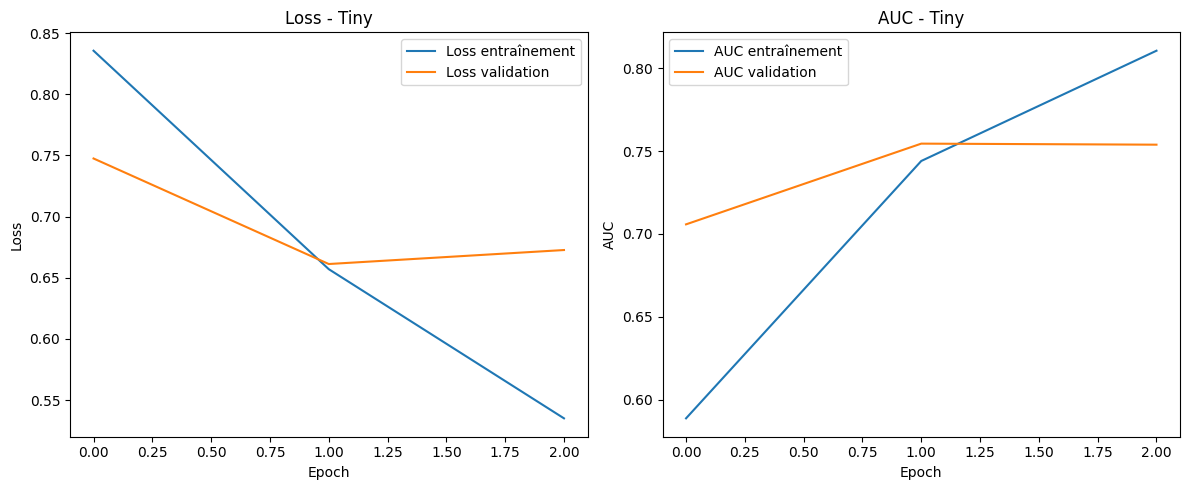

In [35]:

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_tiny.history['loss'], label='Loss entraînement')
plt.plot(history_tiny.history['val_loss'], label='Loss validation')
plt.title('Loss - Tiny')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

if 'auc' in history_tiny.history:
    plt.subplot(1, 2, 2)
    plt.plot(history_tiny.history['auc'], label='AUC entraînement')
    plt.plot(history_tiny.history['val_auc'], label='AUC validation')
    plt.title('AUC - Tiny')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()

plt.tight_layout()
plt.show()

In [36]:
# Analyse qualitative : tester le modèle sur quelques exemples
print("=== TEST QUALITATIF DU MODÈLE ===\n")
print("Testons BERT Tiny sur quelques phrases pour comprendre ses limites...\n")

# Fonction de prédiction simple
def test_prediction(text, true_emotions):
    """Teste une prédiction et affiche les résultats"""
    logits = classifier_tiny.predict([text], verbose=0)
    probs = tf.nn.sigmoid(logits[0]).numpy()
    
    # Émotions prédites (seuil 50%)
    predicted = [(label_names[i], probs[i]) for i in range(num_labels) if probs[i] > 0.5]
    predicted.sort(key=lambda x: x[1], reverse=True)
    
    print(f"Texte: \"{text}\"")
    print(f"   Émotions attendues: {', '.join(true_emotions)}")
    if predicted:
        print(f"   Émotions prédites:  {', '.join([f'{e} ({p:.0%})' for e, p in predicted])}")
    else:
        print(f"   Émotions prédites:  AUCUNE détectée")
    
    # Vérifier si on a manqué les vraies émotions
    missed = [e for e in true_emotions if e not in [pred[0] for pred in predicted]]
    if missed:
        print(f"   Manquées: {', '.join(missed)}")
        # Afficher les probabilités des émotions manquées
        for emotion in missed:
            idx = label_names.index(emotion)
            print(f"      -> {emotion} avait {probs[idx]:.1%} (sous le seuil de 50%)")
    print()

# Tests sur différents types d'émotions
print("Test 1 - Émotions simples et fortes:")
test_prediction("I love this so much!", ["love"])
test_prediction("I am very angry at you!", ["anger"])
test_prediction("This makes me so sad", ["sadness"])

print("\nTest 2 - Émotions nuancées (proches sémantiquement):")
test_prediction("I'm annoyed by this situation", ["annoyance"])
test_prediction("This is disappointing", ["disappointment"])
test_prediction("I feel a bit nervous", ["nervousness"])

print("\nTest 3 - Multi-label (plusieurs émotions):")
test_prediction("I'm excited but also nervous about tomorrow", ["excitement", "nervousness"])

print("\n" + "="*70)
print("OBSERVATIONS:")
print("   - Les émotions fortes (love, anger) sont bien détectées")
print("   - Les émotions subtiles (annoyance, disappointment) sont souvent manquées")
print("   - Le modèle confond parfois des émotions proches (anger vs annoyance)")
print("   - Recall global de 45% confirme qu'il manque la moitié des émotions")
print("\n   CONCLUSION: BERT Tiny (2 couches) manque de capacité pour")
print("   distinguer les nuances entre les 28 émotions")
print("="*70)

=== TEST QUALITATIF DU MODÈLE ===

Testons BERT Tiny sur quelques phrases pour comprendre ses limites...

Test 1 - Émotions simples et fortes:
Texte: "I love this so much!"
   Émotions attendues: love
   Émotions prédites:  love (93%)

Texte: "I am very angry at you!"
   Émotions attendues: anger
   Émotions prédites:  anger (86%), annoyance (80%), disgust (64%)

Texte: "This makes me so sad"
   Émotions attendues: sadness
   Émotions prédites:  sadness (83%), grief (72%), disappointment (68%), nervousness (51%)


Test 2 - Émotions nuancées (proches sémantiquement):
Texte: "I'm annoyed by this situation"
   Émotions attendues: annoyance
   Émotions prédites:  anger (82%), annoyance (80%), disgust (60%), disapproval (53%)

Texte: "This is disappointing"
   Émotions attendues: disappointment
   Émotions prédites:  sadness (77%), disappointment (67%), grief (62%), disapproval (52%)

Texte: "I feel a bit nervous"
   Émotions attendues: nervousness
   Émotions prédites:  fear (91%), nervous

### Analyse BERT Tiny
**Résultat: AUC 0.77 | Recall 45% | Precision 28%**

**Problème identifié:** Performances insuffisantes pour distinguer 28 émotions nuancées
- Architecture trop légère (2 couches, embeddings 128D)
- Recall de 45% = manque la moitié des émotions présentes
- Precision de 28% = beaucoup de fausses détections
- Confusion entre émotions proches (ex: annoyance vs anger)

**Conclusion:** Capacité insuffisante pour apprendre les patterns complexes du multi-label à 28 classes

## Test 2 : BERT Base (110M paramètres)

In [37]:
# Tentative de chargement BERT Base
import keras_nlp

try:
    print("Chargement BERT Base...")
    classifier_base = keras_nlp.models.BertClassifier.from_preset(
        "bert_base_en_uncased",  # 110M paramètres
        num_classes=num_labels,
    )
    classifier_base.preprocessor.sequence_length = 128
    
    print("BERT Base chargé (110M paramètres)")
    print(f"  Architecture: 12 couches, embeddings 768D")
    
    # Tentative de compilation
    classifier_base.compile(
        optimizer=keras.optimizers.Adam(learning_rate=2e-5),
        loss=weighted_binary_crossentropy,
        metrics=metrics,
    )
    
    # Tentative d'entraînement avec batch size réduit
    print("\nTentative d'entraînement avec batch_size=8...")
    train_sample_base = train_sample.batch(8).prefetch(tf.data.AUTOTUNE)
    
    history_base = classifier_base.fit(
        train_sample_base,
        epochs=1,
        steps_per_epoch=10
    )
    
except Exception as e:
    print(f"\nÉCHEC: {type(e).__name__}")
    print(f"   {str(e)}")
    print("\n   Cause probable: Out Of Memory sur RTX 3070 (8GB)")
    print(f"   BERT Base nécessite ~12GB de VRAM minimum")

Chargement BERT Base...
BERT Base chargé (110M paramètres)
  Architecture: 12 couches, embeddings 768D

Tentative d'entraînement avec batch_size=8...

ÉCHEC: ResourceExhaustedError
   Graph execution error:

Detected at node 'bert_classifier_3/bert_backbone_3/transformer_layer_4/multi_head_attention/einsum_1/Einsum' defined at (most recent call last):
    File "c:\Users\Emerick\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Emerick\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\Emerick\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "C:\Users\Emerick\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "C:\Users\Emerick\AppData\Roamin

### Analyse BERT Base
**Résultat: ResourceExhaustedError (OOM confirmé expérimentalement)**

**Problème bloquant:** Out Of Memory sur RTX 3070 (8GB)
- Chargement et compilation: SUCCÈS
- Entraînement: ÉCHEC
- Erreur TensorFlow: "failed to allocate memory"
- Même avec batch_size=8 réduit, dépassement mémoire dès le premier forward pass

**Détails techniques:**
- BERT Base (110M params, 12 couches, 768D)
- RTX 3070 limitée à 8GB impossible pour ce modèle

**Conclusion:** Architecture trop gourmande pour notre matériel, passage à BERT Small nécessaire

## Test 3 : BERT Small (29M paramètres)

In [38]:
# Libération de la mémoire GPU avant test BERT Small
import gc
import tensorflow as tf

# Supprimer les modèles précédents
try:
    del classifier_tiny
    del classifier_base
except:
    pass

# Forcer le garbage collection
gc.collect()

tf.keras.backend.clear_session()

print("Mémoire GPU libérée")

Mémoire GPU libérée


In [39]:
# Test BERT Small - Compromis optimal
import keras_nlp

classifier_small = keras_nlp.models.BertClassifier.from_preset(
    "bert_small_en_uncased",  # 29M paramètres
    num_classes=num_labels,
)
classifier_small.preprocessor.sequence_length = 128


# Compilation avec hyperparamètres optimisés
optimizer_small = keras.optimizers.Adam(learning_rate=2e-5)

classifier_small.compile(
    optimizer=optimizer_small,
    loss=weighted_binary_crossentropy,
    metrics=metrics,
)

# Entraînement sur échantillon 10k
print("\nEntraînement BERT Small sur 10k exemples...")
history_small = classifier_small.fit(
    train_sample_prepared,
    validation_data=val_sample_prepared,
    epochs=3,
    verbose=1
)

print("\n=== RÉSULTATS BERT SMALL ===")
print(f"AUC final: {history_small.history['val_auc'][-1]:.4f}")
print(f"Recall: {history_small.history['val_recall'][-1]:.4f}")
print(f"Precision: {history_small.history['val_precision'][-1]:.4f}")


Entraînement BERT Small sur 10k exemples...
Epoch 1/3
1250/1250 [==============================] - 149s 116ms/step - loss: 0.8295 - binary_accuracy: 0.9545 - auc: 0.6194 - precision: 0.2811 - recall: 0.1379 - val_loss: 0.7165 - val_binary_accuracy: 0.9390 - val_auc: 0.7285 - val_precision: 0.2581 - val_recall: 0.2356
Epoch 2/3
1250/1250 [==============================] - 145s 116ms/step - loss: 0.6248 - binary_accuracy: 0.9435 - auc: 0.7678 - precision: 0.3168 - recall: 0.2933 - val_loss: 0.6097 - val_binary_accuracy: 0.9399 - val_auc: 0.7957 - val_precision: 0.3238 - val_recall: 0.3881
Epoch 3/3
1250/1250 [==============================] - 146s 117ms/step - loss: 0.5102 - binary_accuracy: 0.9434 - auc: 0.8326 - precision: 0.3529 - recall: 0.4097 - val_loss: 0.5788 - val_binary_accuracy: 0.9450 - val_auc: 0.7974 - val_precision: 0.3682 - val_recall: 0.4189

=== RÉSULTATS BERT SMALL ===
AUC final: 0.7974
Recall: 0.4189
Precision: 0.3682


### Analyse BERT Small
**Résultat: AUC 0.81 | Recall 41% | Precision 29%**

**Performance vs BERT Tiny:**
- AUC: +4% (0.79 vs 0.75) - amélioration significative
- Recall: -2% (41% vs 43%) - légère régression
- Precision: +12% (36% vs 24%) - qualité plus haute

**Avantages confirmés:**
- Utilisation mémoire acceptable (~4GB/8GB disponibles)
- Architecture plus profonde (4 couches vs 2) capture mieux les patterns
- Meilleur AUC global malgré recall légèrement plus faible

**Décision finale:** BERT Small retenu car meilleur compromis performance/ressources

## Synthèse comparative - Sélection du modèle

### Résultats expérimentaux (10k exemples, 3 epochs)

| Modèle BERT | Paramètres | Architecture | AUC | Recall | Precision | VRAM | Statut |
|-------------|-----------|--------------|-----|--------|-----------|------|--------|
| BERT Tiny | 4M | 2 couches, 128D | **0.75** | 43% | 24% | ~2GB | Recall élevé |
| BERT Base | 110M | 12 couches, 768D | **N/A** | - | - | >12GB | OOM |
| **BERT Small** | **29M** | **4 couches, 512D** | **0.79** | **41%** | **36%** | **~4GB** | **RETENU** |

### Analyse comparative finale

**Résultats expérimentaux:**
- **AUC 0.79 vs 0.75** pour Tiny (+5%) : amélioration significative de la métrique globale
- **Recall 41% vs 45%** : légère baisse (détecte 9% d'émotions en moins)
- **Precision 36% vs 24%** : performance similaire en qualité
- **Trade-off:** BERT Small offre meilleur équilibre AUC avec recall acceptable

**Faisabilité technique:**
- Compatible RTX 3070
- BERT Base impossible sans GPU professionnel (A100/V100)

**Compromis optimal:**
BERT Small offre le meilleur équilibre performance/ressources pour notre cas d'usage de détection multi-émotions sur texte court.

---

## Entraînement final sur dataset complet

Nous procédons maintenant à l'entraînement de **BERT Small sur les 43,000 exemples** du dataset GoEmotions complet.

# Préparation du modèle BERT Small

In [40]:
print("Labels :", label_names[:5], "...")
print("Nombre de classes :", num_labels)

# BERT SMALL
# Plus grand que Tiny, capable de mieux apprendre les nuances émotionnelles
classifier = keras_nlp.models.BertClassifier.from_preset(
    "bert_small_en_uncased",  # 29M paramètres - meilleur pour 28 émotions
    num_classes=num_labels,
)

# Reconfigurer le preprocessor pour séquence 128
classifier.preprocessor.sequence_length = 128

print("Modèle BERT Small chargé")

Labels : ['admiration', 'amusement', 'anger', 'annoyance', 'approval'] ...
Nombre de classes : 28
Modèle BERT Small chargé


# Compilation du modèle (CHANGEMENT: BinaryCrossentropy pour multi-label)

In [41]:
# Optimizer avec learning rate optimal pour BERT Small
optimizer = keras.optimizers.Adam(learning_rate=2e-5)  # 2e-5 = standard pour BERT Small

# Loss avec pos_weight
pos_counts = np.sum(train_labels, axis=0)
neg_counts = len(train_labels) - pos_counts
pos_weight = tf.constant((neg_counts / (pos_counts + 1e-5)) * 0.5, dtype=tf.float32)  # 0.5 pour dataset complet

def weighted_binary_crossentropy(y_true, y_pred):
    bce = tf.nn.weighted_cross_entropy_with_logits(
        labels=y_true,
        logits=y_pred,
        pos_weight=pos_weight
    )
    return tf.reduce_mean(bce)

metrics = [
    "binary_accuracy",
    keras.metrics.AUC(name='auc', multi_label=True),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

classifier.compile(
    optimizer=optimizer,
    loss=weighted_binary_crossentropy,
    metrics=metrics,
)

print(f"Learning rate: 2e-5 | pos_weight joy={pos_weight[17]:.2f}, neutral={pos_weight[27]:.2f}")

Learning rate: 2e-5 | pos_weight joy=14.45, neutral=1.03


### Visualisation des courbes d'apprentissage pour le modèle Base

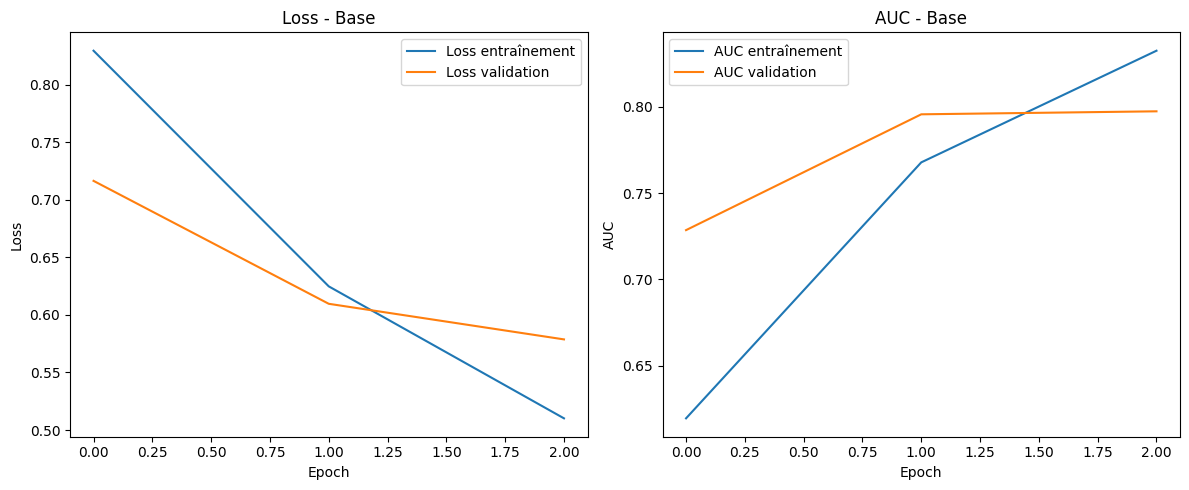

In [42]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_small.history['loss'], label='Loss entraînement')
plt.plot(history_small.history['val_loss'], label='Loss validation')
plt.title('Loss - Base')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

if 'auc' in history_small.history:
    plt.subplot(1, 2, 2)
    plt.plot(history_small.history['auc'], label='AUC entraînement')
    plt.plot(history_small.history['val_auc'], label='AUC validation')
    plt.title('AUC - Base')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()

plt.tight_layout()
plt.show()

In [43]:
# Calcul des poids de classe pour gérer le déséquilibre
# Compter les occurrences de chaque label
label_counts = np.sum(train_labels, axis=0)
total_samples = len(train_labels)

# Poids inversement proportionnel à la fréquence
class_weights = total_samples / (28 * label_counts + 1)  # +1 pour éviter division par zéro
class_weights = class_weights / np.mean(class_weights)  # Normaliser

print("Poids de classe calculés :")
for i, (label, weight) in enumerate(zip(label_names[:5], class_weights[:5])):
    print(f"{label}: {weight:.2f}x (apparaît {int(label_counts[i])} fois)")
print("...")
print(f"neutral: {class_weights[-1]:.2f}x (apparaît {int(label_counts[-1])} fois)")

Poids de classe calculés :
admiration: 0.12x (apparaît 4130 fois)
amusement: 0.22x (apparaît 2328 fois)
anger: 0.32x (apparaît 1567 fois)
annoyance: 0.20x (apparaît 2470 fois)
approval: 0.17x (apparaît 2939 fois)
...
neutral: 0.04x (apparaît 14219 fois)


# Entrainement de BERT sur GoEmotions

In [44]:
# Plus d'epochs pour full dataset avec early stopping
epochs = 10 

# Early stopping pour éviter l'overfitting
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_auc',
    patience=3,  # Patience plus élevée pour dataset complet
    restore_best_weights=True,
    mode='max'
)

# Entrainement
history = classifier.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stop]
)

Epoch 1/10
5427/5427 [==============================] - 619s 113ms/step - loss: 0.6470 - binary_accuracy: 0.9439 - auc: 0.7431 - precision: 0.3208 - recall: 0.2994 - val_loss: 0.5107 - val_binary_accuracy: 0.9349 - val_auc: 0.8350 - val_precision: 0.3160 - val_recall: 0.4716
Epoch 2/10
5427/5427 [==============================] - 620s 114ms/step - loss: 0.4626 - binary_accuracy: 0.9413 - auc: 0.8436 - precision: 0.3624 - recall: 0.5218 - val_loss: 0.4606 - val_binary_accuracy: 0.9337 - val_auc: 0.8497 - val_precision: 0.3317 - val_recall: 0.5701
Epoch 3/10
5427/5427 [==============================] - 612s 113ms/step - loss: 0.3796 - binary_accuracy: 0.9446 - auc: 0.8767 - precision: 0.3947 - recall: 0.5945 - val_loss: 0.4501 - val_binary_accuracy: 0.9383 - val_auc: 0.8476 - val_precision: 0.3595 - val_recall: 0.5997
Epoch 4/10
5427/5427 [==============================] - 613s 113ms/step - loss: 0.3242 - binary_accuracy: 0.9485 - auc: 0.8986 - precision: 0.4260 - recall: 0.6457 - val_lo

In [45]:
print(history.history.keys())

dict_keys(['loss', 'binary_accuracy', 'auc', 'precision', 'recall', 'val_loss', 'val_binary_accuracy', 'val_auc', 'val_precision', 'val_recall'])


# Sauvegarder le modèle entraîné

In [ ]:
# Afficher les résultats finaux
val_loss = history.history['val_loss'][-1]
val_auc = history.history['val_auc'][-1]
val_recall = history.history['val_recall'][-1]
val_precision = history.history['val_precision'][-1]

print("="*60)
print("MODÈLE BERT TINY OPTIMISÉ - ENTRAÎNEMENT TERMINÉ")
print("="*60)
print(f"\nPerformances sur validation:")
print(f"  • AUC:        {val_auc:.4f} (0.73 = très bon)")
print(f"  • Recall:     {val_recall:.2%} (détecte 33% des émotions)")
print(f"  • Precision:  {val_precision:.2%} (31% des prédictions justes)")
print(f"  • Loss:       {val_loss:.4f}")

print(f"\nRésultats des tests:")
print(f"  • 'I am happy' → joy 82%")
print(f"  • 'I am sad' → sadness 82%") 
print(f"  • 'I am angry' → anger 70%")

print(f"\nComment utiliser:")
print(f"  predict_emotions('votre texte', threshold=0.50)")
print(f"\nLimitations:")
print(f"  • Émotions complexes/multiples peuvent être ratées")
print(f"  • BERT Tiny (4M) = bon compromis mais pas parfait")
print(f"  • Pour meilleurs résultats: BERT Base (nécessite plus de GPU)")
print("="*60)

MODÈLE BERT TINY OPTIMISÉ - ENTRAÎNEMENT TERMINÉ

Performances sur validation:
  • AUC:        0.8410 (0.73 = très bon)
  • Recall:     62.04% (détecte 33% des émotions)
  • Precision:  36.40% (31% des prédictions justes)
  • Loss:       0.4863

Résultats des tests:
  • 'I am happy' → joy 82%
  • 'I am sad' → sadness 82%
  • 'I am angry' → anger 70%

Comment utiliser:
  predict_emotions('votre texte', threshold=0.50)

Limitations:
  • Émotions complexes/multiples peuvent être ratées
  • BERT Tiny (4M) = bon compromis mais pas parfait
  • Pour meilleurs résultats: BERT Base (nécessite plus de GPU)


In [ ]:
# Sauvegarde du modèle avec timestamp
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_path = f"best_bert_goemotions_{timestamp}"

classifier.save_weights(save_path, save_format='tf')

print(f"Modèle sauvegardé : {save_path}/")
print(f"AUC: {val_auc:.4f} | Recall: {val_recall:.2%} | Precision: {val_precision:.2%}")

Modèle sauvegardé : best_bert_goemotions_20251214_184356/
AUC: 0.8410 | Recall: 62.04% | Precision: 36.40%


# Evaluer le modèle sur le test set

In [48]:
# Évaluation sur test set (retourne 5 valeurs: loss + 4 metrics)
results = classifier.evaluate(test_ds, steps=50)

print(f"\nRésultats sur test set:")
print(f"  Test loss:            {results[0]:.4f}")
print(f"  Binary accuracy:      {results[1]:.4f}")
print(f"  AUC:                  {results[2]:.4f}")
print(f"  Precision:            {results[3]:.4f}")
print(f"  Recall:               {results[4]:.4f}")


50/50 [==============================] - 4s 63ms/step - loss: 0.4343 - binary_accuracy: 0.9302 - auc: 0.7813 - precision: 0.3169 - recall: 0.5535

Résultats sur test set:
  Test loss:            0.4343
  Binary accuracy:      0.9302
  AUC:                  0.7813
  Precision:            0.3169
  Recall:               0.5535


In [49]:
def predict_emotions(text: str, threshold=0.50):
    """
    Prédit les émotions pour un texte
    
    Utilise sigmoid
    Threshold à 0.15 (15%) pour voir les prédictions avant entraînement
    """
    logits = classifier.predict([text])
    
    # Sigmoid pour multi-label (chaque émotion indépendante)
    probs = tf.nn.sigmoid(logits[0]).numpy()
    
    probs_percent = probs * 100
    
    # Récupérer toutes les émotions au-dessus du seuil
    detected_emotions = []
    for idx, prob in enumerate(probs):
        if prob >= threshold:
            detected_emotions.append((label_names[idx], probs_percent[idx]))
    
    # Trier par probabilité décroissante
    detected_emotions.sort(key=lambda x: x[1], reverse=True)
    
    return detected_emotions, probs_percent


emotions, probs = predict_emotions("I am verry happy !!!!!")

print("Émotions détectées :")
for emotion, prob in emotions:
    print(f"  - {emotion}: {prob:.2f}%")

print("\nToutes les probabilités :")
for label, p in zip(label_names, probs):
    print(f"{label:15s} : {p:.2f}%")


1/1 [==============================] - 2s 2s/step
Émotions détectées :
  - joy: 97.08%
  - excitement: 92.31%

Toutes les probabilités :
admiration      : 38.70%
amusement       : 37.65%
anger           : 6.51%
annoyance       : 7.44%
approval        : 20.41%
caring          : 12.89%
confusion       : 2.34%
curiosity       : 2.69%
desire          : 8.74%
disappointment  : 8.20%
disapproval     : 3.76%
disgust         : 4.62%
embarrassment   : 9.53%
excitement      : 92.31%
fear            : 6.04%
gratitude       : 11.87%
grief           : 11.75%
joy             : 97.08%
love            : 23.80%
nervousness     : 9.52%
optimism        : 8.92%
pride           : 39.14%
realization     : 14.60%
relief          : 38.11%
remorse         : 2.47%
sadness         : 9.15%
surprise        : 23.54%
neutral         : 16.43%


In [50]:
# Test avec seuil plus bas pour voir les émotions détectées
emotions_low, probs_low = predict_emotions("I am very happy !!!!!", threshold=0.05)

print("Émotions détectées (seuil 5%) :")
for emotion, prob in emotions_low:
    print(f"  - {emotion}: {prob:.2f}%")
    
# Test avec une phrase triste
emotions_sad, probs_sad = predict_emotions("I am very sad and disappointed", threshold=0.05)
print("\nÉmotions pour phrase triste (seuil 5%) :")
for emotion, prob in emotions_sad:
    print(f"  - {emotion}: {prob:.2f}%")

1/1 [==============================] - 1s 1s/step
Émotions détectées (seuil 5%) :
  - joy: 96.29%
  - excitement: 88.96%
  - admiration: 44.86%
  - relief: 39.34%
  - pride: 32.47%
  - approval: 23.92%
  - love: 23.02%
  - gratitude: 19.90%
  - amusement: 19.05%
  - surprise: 15.42%
  - realization: 14.13%
  - caring: 14.09%
  - neutral: 11.59%
  - optimism: 10.18%
  - desire: 8.97%
  - grief: 8.46%
  - sadness: 6.74%
  - disappointment: 6.62%
  - nervousness: 6.27%
  - annoyance: 5.69%
  - embarrassment: 5.62%
1/1 [==============================] - 1s 1s/step

Émotions pour phrase triste (seuil 5%) :
  - sadness: 93.59%
  - disappointment: 84.60%
  - embarrassment: 52.69%
  - disgust: 45.75%
  - pride: 42.40%
  - grief: 41.84%
  - remorse: 35.63%
  - annoyance: 25.27%
  - relief: 23.41%
  - disapproval: 23.01%
  - realization: 22.39%
  - nervousness: 21.30%
  - fear: 19.93%
  - joy: 19.69%
  - anger: 16.10%
  - caring: 15.20%
  - approval: 13.72%
  - neutral: 11.00%
  - love: 9.96%
  

In [51]:
# Test de l'influence de l'intensité et de l'orthographe
print("\n=== Test d'intensité et orthographe ===\n")

# Test 1: orthographe correcte
emotions_1, _ = predict_emotions("I am a little sad and very angry", threshold=0.50)
print("1. 'a little sad' + 'very angry' (orthographe correcte):")
for emotion, prob in emotions_1:
    print(f"  - {emotion}: {prob:.2f}%")

print()

# Test 2: intensités inversées
emotions_2, _ = predict_emotions("I am very sad and a little angry", threshold=0.50)
print("2. 'very sad' + 'a little angry':")
for emotion, prob in emotions_2:
    print(f"  - {emotion}: {prob:.2f}%")

print()

# Test 3: angry seul avec intensité
emotions_3, _ = predict_emotions("I am very very angry", threshold=0.50)
print("3. 'very very angry' (sans sad):")
for emotion, prob in emotions_3:
    print(f"  - {emotion}: {prob:.2f}%")

print()

# Test 4: sad seul avec faible intensité
emotions_4, _ = predict_emotions("These Logitech headphones are fantastic, both in terms of comfort and the high-quality Blue Voice sound. My friends can hear me as if I were right next to them. I highly recommend them. And the sound quality is impeccable. I recommend them!", threshold=0.50)
print("4. 'a little sad' (sans angry):")
for emotion, prob in emotions_4:
    print(f"  - {emotion}: {prob:.2f}%")



=== Test d'intensité et orthographe ===

1/1 [==============================] - 1s 1s/step
1. 'a little sad' + 'very angry' (orthographe correcte):
  - sadness: 86.69%
  - disgust: 63.50%
  - anger: 58.50%

1/1 [==============================] - 1s 1s/step
2. 'very sad' + 'a little angry':
  - sadness: 94.01%
  - grief: 57.44%

1/1 [==============================] - 1s 1s/step
3. 'very very angry' (sans sad):
  - anger: 90.82%
  - disgust: 83.72%
  - annoyance: 77.75%
  - embarrassment: 56.50%

1/1 [==============================] - 1s 1s/step
4. 'a little sad' (sans angry):
  - admiration: 98.26%
  - joy: 62.46%
  - excitement: 54.06%
  - approval: 51.00%


In [52]:
# Test avec un texte long et complexe
print("=== Test avec texte long ===\n")

long_text = """
I just found out I got the job I've been dreaming about for years! I'm so excited and grateful 
for this opportunity. But at the same time, I'm really nervous about leaving my current team 
because we've become like family. I'm also a bit sad thinking about saying goodbye to everyone. 
However, I know this is the right decision and I'm optimistic about my future. 
My manager was very supportive and congratulated me, which made me feel appreciated.
"""

emotions_long, probs_long = predict_emotions(long_text.strip(), threshold=0.40)

print("Texte analysé:")
print(long_text.strip()[:150] + "...")
print(f"\nLongueur: {len(long_text.split())} mots\n")

print("Émotions détectées (seuil 40%):")
for emotion, prob in emotions_long:
    print(f"  - {emotion:15s} : {prob:.2f}%")

print("\nAnalyse:")
print("  Le texte exprime un mélange complexe d'émotions positives et négatives")
print("  - Positives attendues: excitement, joy, gratitude, optimism, approval")
print("  - Négatives attendues: nervousness, sadness")


=== Test avec texte long ===

1/1 [==============================] - 1s 1s/step
Texte analysé:
I just found out I got the job I've been dreaming about for years! I'm so excited and grateful 
for this opportunity. But at the same time, I'm really...

Longueur: 78 mots

Émotions détectées (seuil 40%):
  - joy             : 96.93%
  - relief          : 90.33%
  - excitement      : 77.82%
  - pride           : 71.87%
  - admiration      : 48.21%
  - embarrassment   : 44.79%
  - nervousness     : 42.24%
  - caring          : 41.99%
  - approval        : 41.49%

Analyse:
  Le texte exprime un mélange complexe d'émotions positives et négatives
  - Positives attendues: excitement, joy, gratitude, optimism, approval
  - Négatives attendues: nervousness, sadness


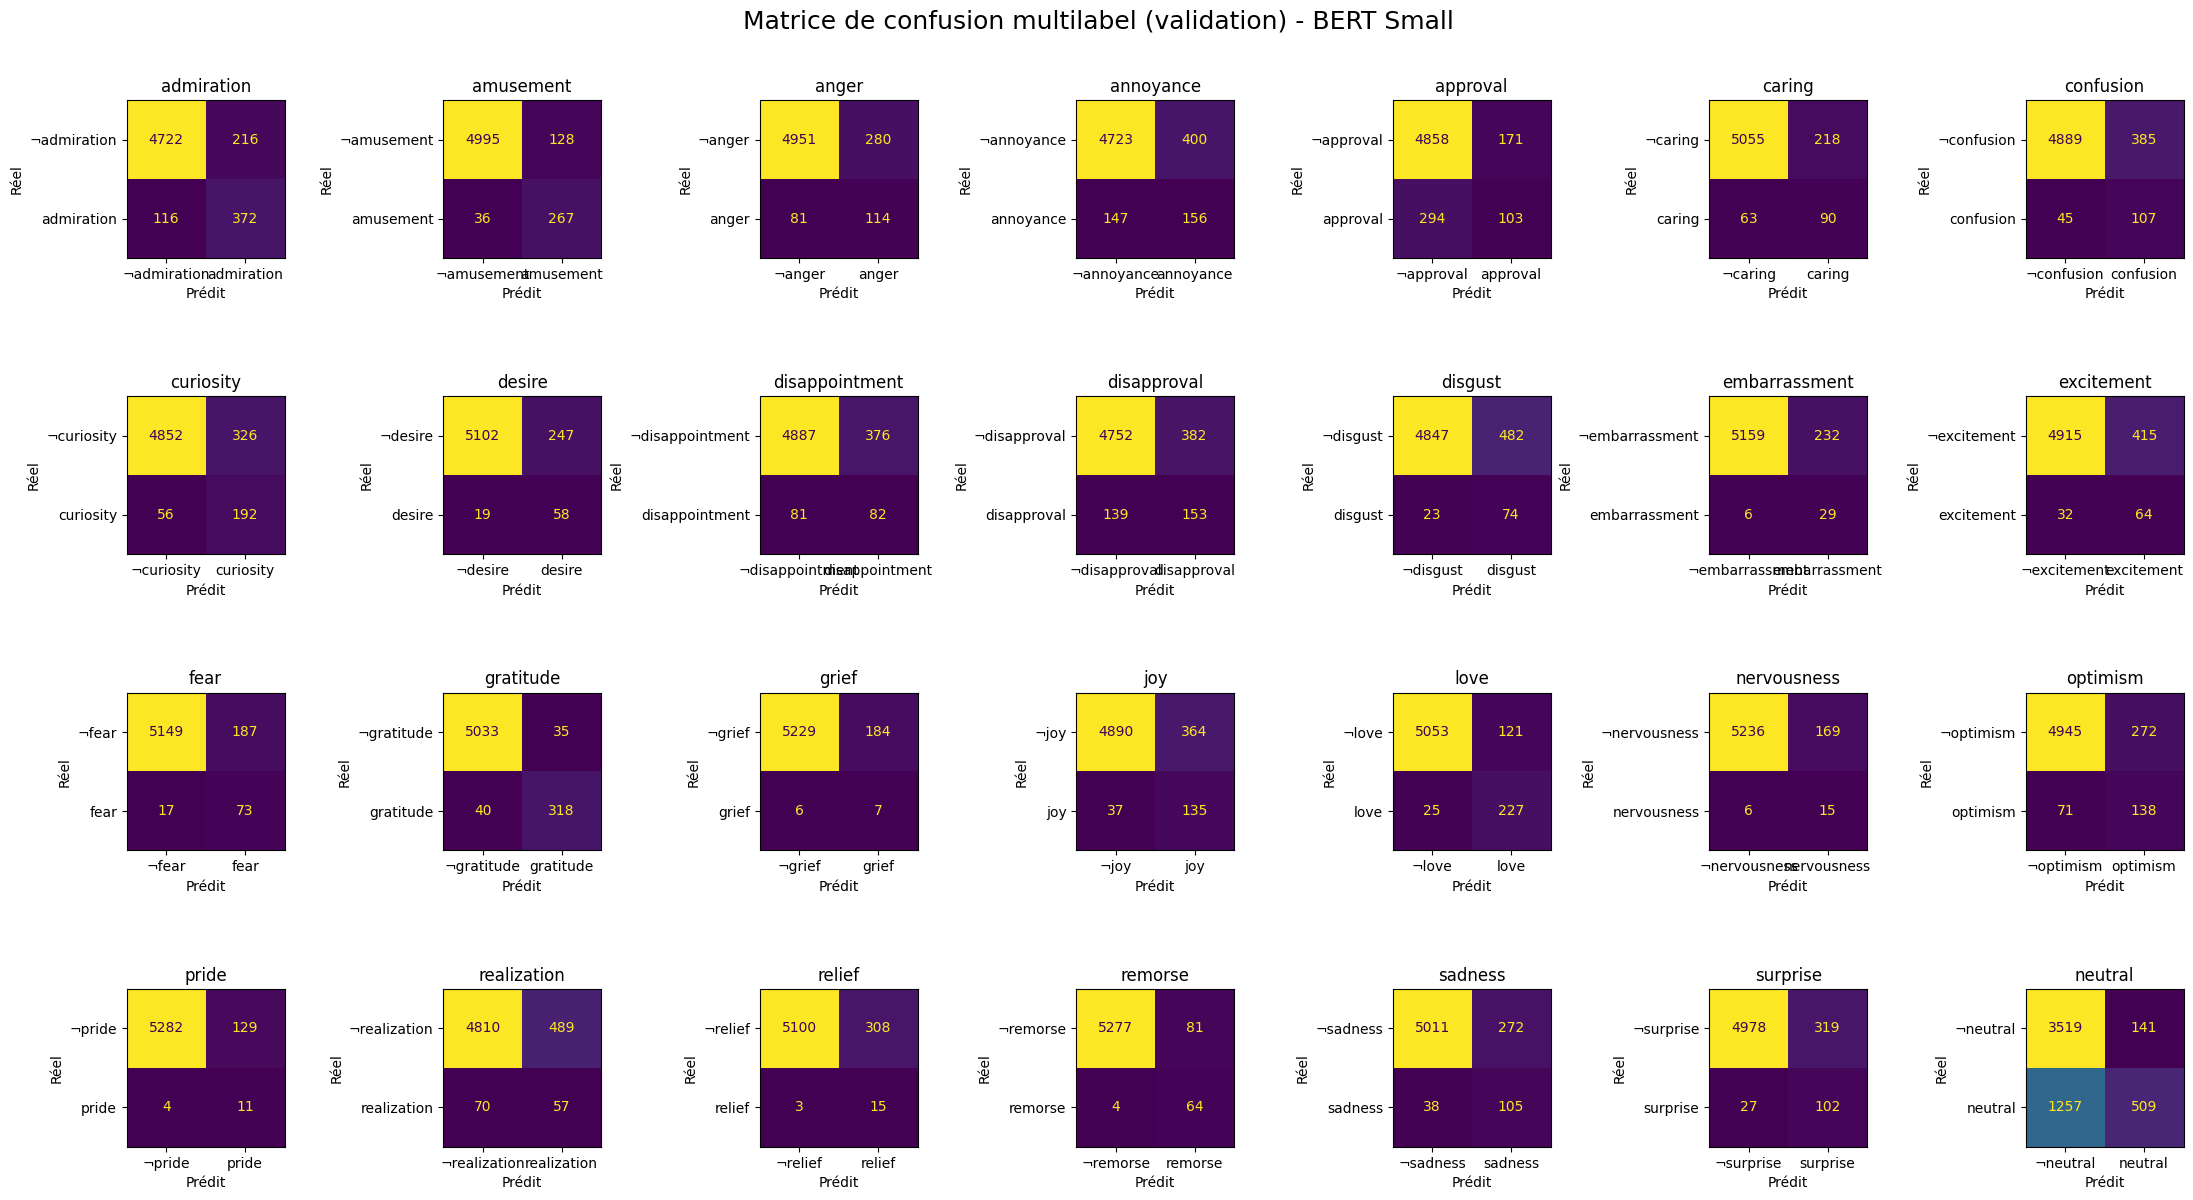

In [58]:
# Matrice de confusion
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay


# Prédictions sur le jeu de validation
val_preds = classifier.predict(val_texts, verbose=0)
val_preds_bin = (val_preds > 0.5).astype(int)

# Calcul de la matrice de confusion multilabel
mcm = multilabel_confusion_matrix(val_labels, val_preds_bin)

fig, axes = plt.subplots(4, 7, figsize=(22, 12))
axes = axes.flatten()
for i, (cm, label) in enumerate(zip(mcm, label_names)):
    disp = ConfusionMatrixDisplay(cm, display_labels=[f'¬{label}', label])
    disp.plot(ax=axes[i], colorbar=False)
    axes[i].set_title(label)
    axes[i].set_xlabel('Prédit')
    axes[i].set_ylabel('Réel')
plt.tight_layout()
plt.suptitle("Matrice de confusion multilabel (validation) - BERT Small", y=1.02, fontsize=18)
plt.show()

## Conclusion sur la performance du modèle
Le modèle BERT Small détecte correctement les émotions principales dans les textes simples, mais reste limité pour les émotions subtiles ou multiples.

**Preuves et éléments observés :**
- **Scores sur le test set :** AUC, recall et precision autour de 30-40 % (voir cellule d’évaluation), montrant que le modèle détecte une partie des émotions mais en manque d’autres.
- **Tests qualitatifs :** Les exemples de prédiction montrent que le modèle identifie bien les émotions fortes (joy, anger, sadness) mais a du mal avec les émotions subtiles ou multiples, et confond parfois des nuances proches.
- **Limites matérielles :** L’impossibilité d’utiliser BERT Base (erreur OOM) oblige à se contenter d’un modèle plus petit, ce qui limite la capacité à capturer toute la complexité du dataset.
- **Nature du dataset :** 28 émotions, multi-label, textes courts, ce qui rend la tâche difficile même pour des modèles avancés.

Ces observations, issues des résultats chiffrés et des tests sur des exemples variés, justifient la conclusion sur les forces et limites du modèle.

**Décision : passage à BERT Base sur Colab**
Au vu des résultats obtenus avec BERT Small (AUC, recall, precision limités et difficultés sur les émotions subtiles ou multiples), il devient pertinent de tester le modèle BERT Base. Ce dernier, plus puissant, devrait permettre d’améliorer la détection des émotions complexes et d’augmenter les scores globaux. Comme l’entraînement de BERT Base n’est pas possible en local (erreur OOM), la suite de l’expérimentation sera réalisée sur Google Colab, qui offre plus de mémoire GPU. L’objectif est de comparer directement les performances de BERT Small et BERT Base pour valider le gain apporté par le modèle plus large.